Necessary imports..

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

Dataset

In [3]:
num_samples = 10000 # size of the positive and negative numbers
## random samples from multivariate normal distribution is generated using np.random.multivariate_normal method
# The coordinate of the mean is (0,3) in N-dimensional space for negative samples and (3,0) for positive samples
# Cov indicates the covariance matrix of the distribution
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
print(negative_samples)
print(positive_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
# This creates 10000 zeros followed by 10000 ones
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),np.ones((num_samples, 1), dtype='float32')))

[[ 0.3178001   1.50813182]
 [-0.34297366  3.53254522]
 [-0.21477887  3.13636337]
 ...
 [ 1.33738159  3.67044588]
 [-1.28575533  1.12921289]
 [-0.05827079  1.26334804]]
[[ 3.22523334  1.22951127]
 [ 4.52954616  1.11436305]
 [ 2.95190822  0.24724444]
 ...
 [ 2.72526542  0.82288762]
 [ 1.64334935 -0.93960556]
 [ 4.83066839  1.77633672]]


Plotting samples

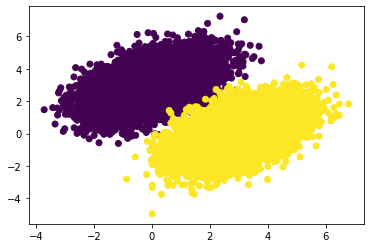

In [4]:
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

Randomize Dataset

In [5]:
indices = np.random.permutation(len(features))
print(indices)
features = features[indices]
labels = labels[indices]

[ 1898  8208  5357 ...  7987 16765  8415]


Linear Classifier

In [6]:
input_dim = 2 
output_dim = 1
learning_rate = 0.01 # Learning rate

# This is our weight matrix. This matrix contain random values from a uniform distribution.
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
print(w)
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))
print(b)


def compute_predictions(features):
  # Multiplies matrix features by matrix w, producing features * w
  # The result is added with bias b
  return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
  # Compute the mean of elements across dimensions of a tensor
  return tf.reduce_mean(tf.square(labels - predictions))

# Compile the training function into a static graph
@tf.function
def train_on_batch(x, y):
  # Compute gradients with GradientTape
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  # adjust network's weights and biases based on gradients of the cost function
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.5391755 ],
       [0.52639973]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


Train classifier batchwise

In [7]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)
t0 = time.time()
for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Epoch 0: last batch loss = 0.0817
Epoch 1: last batch loss = 0.0511
Epoch 2: last batch loss = 0.0514
Epoch 3: last batch loss = 0.0358
Epoch 4: last batch loss = 0.0302
Epoch 5: last batch loss = 0.0400
Epoch 6: last batch loss = 0.0398
Epoch 7: last batch loss = 0.0148
Epoch 8: last batch loss = 0.0189
Epoch 9: last batch loss = 0.0306
Time per epoch: 0.043 s


Evaluate model

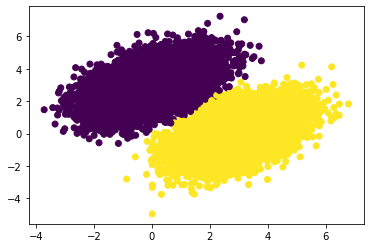

In [8]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)